In [2]:
import numpy as np
import torch
import cv2
from dm_control import suite

import lib_duju.utils as duju_utils

from Model.ReplayBuffer import ReplayBuffer
from Model.ImageBuffer import ImageBuffer
from Model.SAC_base import target_initialize

from Model.triple_dqn import Triple_DQN
from Model.triple_dqn import train_triple_dqn

exp_title = "Conv_Discrete_TDQN_celu_larger networks"
print(exp_title)

train_print_flag = False
eval_print_flag = False

load_flag = False

env = suite.load(domain_name="cartpole",task_name="swingup")

action_dim = 3

# state related variables
step_size = 3
channel_size = 1
height = 48
width = 64
skip_frame = 4

input_channel_size = step_size * channel_size

rb_state_dim = 1
rb_action_dim = 1

action_dict = { 0 : -1.0,
                1 : 1.0,
                2 : 0.0}

reward_compensate = 1

print("reward_compensate", reward_compensate)
print("skip_frame", skip_frame)

lr = 1e-3
gamma = 0.99
device = torch.device("cuda")
max_episode = 10000
batch_size = 32
buffer_size = int(5e5)

replay_buffer = ReplayBuffer(rb_state_dim, rb_action_dim, buffer_size)
image_buffer = ImageBuffer(height, width, step_size, channel_size, int(buffer_size * 1.1))
eval_image_buffer = ImageBuffer(height, width, step_size, channel_size, 2000)

q_main = Triple_DQN(step_size, channel_size, height, width, action_dim, lr, device)
q_target = Triple_DQN(step_size, channel_size, height, width, action_dim, lr, device)

target_initialize(q_main, q_target)

print(q_main)

if load_flag:
    duju_utils.torch_network_load(q_main, "../trained/Conv_Discrete_TDQN_celu_larger networks_q_main_250.torch")
    duju_utils.torch_network_load(q_target, "../trained/Conv_Discrete_TDQN_celu_larger networks_q_target_250.torch")

Conv_Discrete_TDQN_celu_larger networks
reward_compensate 1
skip_frame 4
input channel size :  3
fc input size :  1536
input channel size :  3
fc input size :  1536
Triple_DQN(
  (q1_conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (q1_conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (q1_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (q1_conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (q1_fc1): Linear(in_features=1536, out_features=256, bias=True)
  (q1_fc2): Linear(in_features=256, out_features=256, bias=True)
  (q1_fc3): Linear(in_features=256, out_features=3, bias=True)
  (q2_conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (q2_conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (q2_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (q2_conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), paddi

In [17]:
q_main.optimizer.state_dict()["param_groups"][0]["lr"]

0.001

In [2]:
duju_utils.torch_network_load(q_main,"trained/Conv_Discrete_TDQN_celu_larger networks_q_main_375.torch")
duju_utils.torch_network_load(q_target,"trained/Conv_Discrete_TDQN_celu_larger networks_q_target_375.torch")

In [3]:

for epi_i in range(1, max_episode + 1):
    print(epi_i, end = "\t")

    timestep = env.reset()
    ep_reward = 0.0

    # timestep, reward, discount, observation
    end, _, _, _ = timestep
    end = end.last()

    frame = env.physics.render(camera_id=0, height = height, width =width)
    for _ in range(step_size):
        image_buffer.dm_add_gray(frame)
    s_idx = image_buffer.get_current_index()
    s_frame = image_buffer.get_state(s_idx)

    pseudo_sigma = np.maximum(1- epi_i/100.0, 0.1)
    epsilon = np.random.sample() * 0.1 # mean 0.05 min 0.0 max 0.1

    while not end:
        a_category = q_main.epsilon_sample(
                        torch.FloatTensor(s_frame).to(device).view(1, input_channel_size, height, width),
                        epsilon
                )
        a_deploy = action_dict[a_category]

        for _ in range(skip_frame):
            timestep = env.step(a_deploy)

        end, r, _, _ = timestep
        end = end.last()
        frame = env.physics.render(camera_id=0, height=height, width=width)
        image_buffer.dm_add_gray(frame)

        s2_idx = image_buffer.get_current_index()
        s2_frame = image_buffer.get_state(s2_idx)

        replay_buffer.add(  np.array([s_idx]),
                          np.array([a_category]),
                          np.array([r * reward_compensate]),
                          np.array([end]),
                          np.array([s2_idx])    )

        frame = env.physics.render(camera_id=0, height=480, width=640)  # [height, width, channel]

        if train_print_flag:
            #cv2.imshow("train", cv2.resize(np.moveaxis(s2_frame,[0,1,2],[2,0,1]),(width*4,height*4)))
            cv2.imshow("train", frame)
            cv2.waitKey(1)

        s_idx = s2_idx
        s_frame = s2_frame

        ep_reward += r * skip_frame

    for _idx in range(int(1000)):
        #print(_idx)
            mean_q1, max_q1, min_q1, mean_q2, mean_reward = train_triple_dqn(q_main, q_target, replay_buffer, image_buffer, batch_size, gamma)

    print(int(ep_reward), "***", (float(mean_q1), float(max_q1), float(min_q1), float(mean_q2), float(mean_reward)))

    #### Eval ####

    timestep = env.reset()
    eval_ep_reward = 0.0
    eval_action = []

    end, _, _, _ = timestep
    end = end.last()

    frame = env.physics.render(camera_id=0, height=height, width=width)
    for _ in range(step_size):
        eval_image_buffer.dm_add_gray(frame)
    s_idx = eval_image_buffer.get_current_index()
    s_frame = eval_image_buffer.get_state(s_idx)

    if (epi_i % 25) == 0 :
        while not end:
            a_category = q_main.epsilon_sample(
                        torch.FloatTensor(s_frame).to(device).view(1, input_channel_size, height, width),
                        0.0
                                                  )
            a_deploy = action_dict[a_category]
            eval_action.append(a_deploy)

            for _ in range(skip_frame):
                timestep = env.step(a_deploy)

            end, r, _, _ = timestep
            end = end.last()
            frame = env.physics.render(camera_id=0, height=height, width=width)
            eval_image_buffer.dm_add_gray(frame)

            s2_idx = eval_image_buffer.get_current_index()
            s2_frame = eval_image_buffer.get_state(s2_idx)

            s_idx = s2_idx
            s_frame = s2_frame

            eval_ep_reward += r * skip_frame

            # frame = env.physics.render(camera_id=0, height=480, width=640) #[height, width, channel]
            if eval_print_flag:
                cv2.imshow("eval", cv2.resize(np.moveaxis(s2_frame,[0,1,2],[2,0,1]),(width*8,height*8)))
                cv2.waitKey(1)


        print("Eval! *** ", eval_ep_reward)
        #print(eval_action)

    if (epi_i % 25) == 0:
        print("Networks Saved!")
        duju_utils.torch_network_save(q_main,"../trained/"+exp_title+"_q_main_"+str(epi_i)+".torch")
        duju_utils.torch_network_save(q_target, "../trained/"+exp_title+"_q_target_"+str(epi_i)+".torch")

cv2.destroyAllWindows()

1	556 *** (524.4137573242188, -319.7030029296875, 1050.72705078125, 516.1741943359375, 5.585254669189453)
2	

KeyboardInterrupt: 

In [5]:
import matplotlib.pyplot as plt

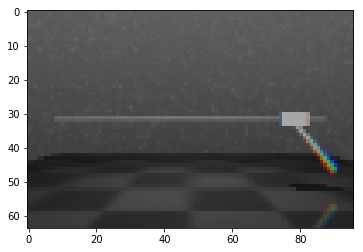

In [6]:
f = image_buffer.get_state(450)

plt.imshow(np.moveaxis(f,[0,1,2],[2,0,1]))

In [7]:
fs = []
for i in range(100,500):
    fs.append(image_buffer.get_state(i))

In [10]:
f3s = []
for f in fs:
    c1 = q_main.q1_conv1(torch.FloatTensor(f).view([-1,3,64,96]).to(device))
    cc1 = torch.celu(c1)

    c2 = q_main.q1_conv2(cc1)
    cc2 = torch.celu(c2)

    c3 = q_main.q1_conv3(cc2)
    cc3 = torch.celu(c3)
    
    c4 = q_main.q1_conv4(cc3)
    cc4 = torch.celu(c4)
    
    c5 = q_main.q1_conv5(cc4)
    cc5 = torch.celu(c5)

    i0 = cc5.view([1,-1])

    f1 = q_main.q1_fc1(i0)
    ff1 = torch.celu(f1)

    f2 = q_main.q1_fc2(ff1)
    ff2 = torch.celu(f2)
    
    f3 = q_main.q1_fc3(ff2)
    f3s.append(f3)
    
f3s

[tensor([[123.5664, 122.9472, 118.7792]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[127.4890, 127.4222, 123.6236]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[127.8568, 125.6638, 123.5442]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[133.3371, 133.3248, 129.3734]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[134.4424, 134.0248, 129.3910]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[144.0959, 144.5748, 139.2695]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[148.0049, 147.7655, 143.0349]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[150.5099, 148.3111, 144.9536]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[142.6510, 138.8964, 136.2307]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[137.5677, 135.2110, 131.6022]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[141.3046, 139.9668, 136.2239]], device='cuda:0',
        gra

In [15]:
torch.min(q_main.q1_fc2.weight)

tensor(-1.8682, device='cuda:0', grad_fn=<MinBackward1>)

In [ ]:
c1 = q_main.q1_conv1(torch.FloatTensor(f).view([-1,3,64,96]).to(device))
cc1 = torch.celu(c1)

c2 = q_main.q1_conv2(cc1)
cc2 = torch.celu(c2)

c3 = q_main.q1_conv3(cc2)
cc3 = torch.celu(c3)

i0 = cc3.view([1,-1])

f1 = q_main.q1_fc1(i0)
ff1 = torch.celu(f1)

f2 = q_main.q1_fc2(ff1)

In [ ]:
torch.sum(ff1 > 0)

In [ ]:
f2

In [ ]:
for i in cc3[0]:
    print(i)

In [ ]:
for i in i0.detach().cpu().numpy()[0]:
    print(i, end=", ")

In [ ]:
ff1

In [ ]:
f2